In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('cbi')
%matplotlib inline

import requests
import re
from bs4 import BeautifulSoup as bs

In [4]:
SEASON_URL_PATTERN = "http://www.basketball-reference.com/playoffs/NBA_{YYYY_season}.html"
SEASON_RANGE =range(1975, 2016)

In [377]:
team_colors = {
	'ATL' : '#E13A3E',
	'BOS' : '#008348',
	'BRK' : '#061922',
	'CHA' : '#1D1160',
	'CHI' : '#CE1141',
	'CLE' : '#860038',
	'DAL' : '#007DC5',
	'DEN' : '#FDB927',
	'DET' : '#ED174C',
	'GSW' : '#FDB927',
	'HOU' : '#FDB927',
	'IND' : '#FFC633',
	'LAC' : '#ED174C',
	'LAL' : '#FDB927',
	'MEM' : '#0F586C',
	'MIA' : '#98002E',
	'MIL' : '#00471B',
	'MIN' : '#005083',
    'NJ' : '#002258 ',
	'NOP' : '#002B5C',
	'NYK' : '#F58426',
	'OKC' : '#007DC3',
	'ORL' : '#C4CED3',
	'PHI' : '#ED174C',
	'PHO' : '#E56020',
	'POR' : '#E03A3E',
	'SAC' : '#724C9F',
	'SAS' : '#BAC3C9',
    'SEA' : '#005831',
	'TOR' : '#CE1141',
	'UTA' : '#002B5C',
	'WAS' : '#002B5C',
    'WSB' : '#002B5C'
}

In [11]:
def get_season_html(season):
    url = SEASON_URL_PATTERN.format(YYYY_season = season)
    html = requests.get(url)
    return html.text

In [12]:
def create_soup_from_html(html_text):
    soup = bs(html_text, 'html.parser')
    return soup

In [218]:
def get_link_to_champion_team_page(soup):
    link = None
    spans = soup.findAll('span')
    for span in spans:
        if span.text == 'League Champion:':
            link = span.findParent('p').find('a').attrs['href']
            link = 'http://www.basketball-reference.com{link}'.format(link = link)
            break
    return link

In [133]:
def get_link_to_games_page(soup):
    tbl_finals = soup.find('table', {'class' : 'small_text'})
    for td in tbl_finals.findAll('td'):
        if 'Series Stats' in td.text:
            link = td.findAll('a')[2].attrs['href']
            link = 'http://www.basketball-reference.com{link}'.format(link = link)
            break
    return link

In [172]:
def get_html(link):
    html = requests.get(link)
    return html.text

In [136]:
def get_roster_tbl_object(soup):
    tbl = soup.find('table', {'id' : 'roster'})
    return tbl

In [149]:
def get_table_columns(tbl):
    cols = []
    for th in tbl.find('thead').findAll('th'):
        cols.append(th.text)
    return cols

In [158]:
def get_player_info(tbl, cols, season, tm):
    players = []
    for tr in tbl.find('tbody').findAll('tr'):
        player = {'season' : season, 'team': tm}
        for ii, td in enumerate(tr.findAll('td')):
            player[cols[ii]] = td.text
        players.append(player)
    return players


In [176]:
def get_stats_tbl(soup, tm):
    tbl = soup.find('table', {'id' : tm})
    return tbl

In [185]:
def get_stats_columns(tbl):
    cols = []
    for th in tbl.find('thead').findAll('tr')[1].findAll('th'):
        cols.append(th.attrs['data-stat'])
    return cols

In [179]:
def get_player_stats(tbl, cols, season, tm):
    players = []
    for tr in tbl.find('tbody').findAll('tr'):
        player = {'season' : season, 'team': tm}
        for ii, td in enumerate(tr.findAll('td')):
            player[cols[ii]] = td.text
        players.append(player)
    return players


In [219]:
players_all = []
stats_all = []
for season in SEASON_RANGE:
    print season
    # Get Links to Team Page and Games Page
    season_html = get_season_html(season)
    season_soup = create_soup_from_html(season_html)
    champ_team_link = get_link_to_champion_team_page(season_soup)
    games_link = get_link_to_games_page(season_soup)

    if champ_team_link is None: 
        print 'error with team link'
        continue
    tm = champ_team_link.replace('http://www.basketball-reference.com/teams/', '').split('/')[0]

    # Get Player Heights and DOBs
    team_html = get_html(champ_team_link)
    team_page_soup = create_soup_from_html(team_html)
    roster_tbl = get_roster_tbl_object(team_page_soup)
    cols = get_table_columns(roster_tbl)
    players = get_player_info(roster_tbl, cols, season, tm)

    # Get Player Minutes
    stats_html = get_html(games_link)
    stats_page_soup = create_soup_from_html(stats_html)
    stats_tbl = get_stats_tbl(stats_page_soup, tm)
    stats_cols = get_stats_columns(stats_tbl)
    stats = get_player_stats(stats_tbl, stats_cols, season, tm)
    
    for p in players: players_all.append(p)
    for s in stats: stats_all.append(s)

1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
error with team link


In [243]:
dfplayers = pd.DataFrame(players_all)

In [241]:
dfstats = pd.DataFrame(stats_all)
dfstats = dfstats[['season', 'team', 'player', 'age', 'mp', 'pts']]

In [221]:
dfstats.age = dfstats.age.astype(int)
dfstats.mp = dfstats.mp.astype(int)
dfstats.pts = dfstats.pts.astype(int)

In [250]:
# 2015
season = 2015
tm = 'GSW'

url = 'http://www.basketball-reference.com/teams/GSW/2015.html'
team_html = get_html(url)
team_page_soup = create_soup_from_html(team_html)
roster_tbl = get_roster_tbl_object(team_page_soup)
cols = get_table_columns(roster_tbl)
players = get_player_info(roster_tbl, cols, season, tm)


url = 'http://www.basketball-reference.com/playoffs/2015-nba-finals-cavaliers-vs-warriors.html'
stats_html = get_html(url)
stats_page_soup = create_soup_from_html(stats_html)
stats_tbl = get_stats_tbl(stats_page_soup, tm)
stats_cols = get_stats_columns(stats_tbl)
stats = get_player_stats(stats_tbl, stats_cols, season, tm)

dfplayers2 = pd.DataFrame(players)

dfstats2 = pd.DataFrame(stats)
dfstats2 = dfstats2[['season', 'team', 'player', 'age', 'mp', 'pts']]

dfstats2.age = dfstats2.age.astype(int)
dfstats2.mp = dfstats2.mp.astype(int)
dfstats2.pts = dfstats2.pts.astype(int)

In [253]:
dfplayers.head()

,Birth Date,College,Exp,Ht,No.,Player,Pos,Wt,season,team
0,"March 28, 1944",University of Miami,8,6-7,24,Rick Barry,SF,205,1975,GSW
1,"May 4, 1947",University of Louisville,4,6-3,21,Butch Beard,PG,185,1975,GSW
2,"August 1, 1950",University of Tulsa,2,6-1,22,Steve Bracey,SG,175,1975,GSW
3,"April 4, 1939",University of Kansas,12,6-6,32,Bill Bridges,PF,228,1975,GSW
4,"March 20, 1951",University of Cincinnati,1,6-7,40,Derrek Dickey,PF,218,1975,GSW


In [251]:
dfplayers2

,,Birth Date,College,Exp,Ht,No.,Player,Pos,Wt,season,team
0,,"November 28, 1984",University of Utah,9,7-0,12,Andrew Bogut,C,245,2015,GSW
1,,"April 29, 1983",University of Florida,9,6-9,10,David Lee,PF,249,2015,GSW
2,,"March 14, 1988",Davidson College,5,6-3,30,Stephen Curry,PG,185,2015,GSW
3,,"July 7, 1985",University of Kansas,6,6-6,4,Brandon Rush,SG,210,2015,GSW
4,,"May 30, 1992",University of North Carolina,2,6-8,40,Harrison Barnes,SF,210,2015,GSW
5,,"February 8, 1990",Washington State University,3,6-7,11,Klay Thompson,SG,205,2015,GSW
6,,"October 21, 1989",Vanderbilt University,1,6-11,31,Festus Ezeli,C,255,2015,GSW
7,,"March 4, 1990",Michigan State University,2,6-7,23,Draymond Green,SF,230,2015,GSW
8,,"April 5, 1989",University of Washington,1,6-6,7,Justin Holiday,SG,185,2015,GSW
9,,"January 28, 1984",University of Arizona,10,6-6,9,Andre Iguodala,SG,207,2015,GSW


In [255]:
df_players_all = pd.concat([dfplayers, dfplayers2], axis= 0).reset_index(drop =True)

In [239]:
df_final=pd.concat([dfstats, dfstats2], axis= 0).reset_index(drop= True)

In [263]:
df_players_all.columns = [c.lower() for c in df_players_all.columns]
df_players_all.head()

,,birth date,college,exp,ht,no.,player,pos,wt,season,team
0,NaN,"March 28, 1944",University of Miami,8,6-7,24,Rick Barry,SF,205,1975,GSW
1,NaN,"May 4, 1947",University of Louisville,4,6-3,21,Butch Beard,PG,185,1975,GSW
2,NaN,"August 1, 1950",University of Tulsa,2,6-1,22,Steve Bracey,SG,175,1975,GSW
3,NaN,"April 4, 1939",University of Kansas,12,6-6,32,Bill Bridges,PF,228,1975,GSW
4,NaN,"March 20, 1951",University of Cincinnati,1,6-7,40,Derrek Dickey,PF,218,1975,GSW


In [260]:
df_final.head()

,season,team,player,age,mp,pts
0,1975,GSW,Rick Barry,30,172,118
1,1975,GSW,Jamaal Wilkes,21,107,46
2,1975,GSW,Phil Smith,22,96,43
3,1975,GSW,Derrek Dickey,23,74,35
4,1975,GSW,Jeff Mullins,32,77,32


In [259]:
df_final.to_csv('nba_finals_age.csv', index = False)

In [266]:
df_all = df_final.merge(df_players_all[['player', 'team', 'season', 'ht']], how = 'left', on = ['player', 'team', 'season'])

In [272]:
df_all['inches'] = df_all.ht.apply(lambda h: int(h.split('-')[0])*12 + int(h.split('-')[1]))

In [312]:
df_all[df_all.season == 1975].sort('mp', ascending = False)

,season,team,player,age,mp,pts,ht,inches,mp_perc,mp_age,mp_inches
0,1975,GSW,Rick Barry,30,172,118,6-7,79,0.179167,5.375000,14.154167
7,1975,GSW,Clifford Ray,26,119,28,6-9,81,0.123958,3.222917,10.040625
1,1975,GSW,Jamaal Wilkes,21,107,46,6-6,78,0.111458,2.340625,8.693750
5,1975,GSW,Charles Johnson,25,98,30,6-0,72,0.102083,2.552083,7.350000
2,1975,GSW,Phil Smith,22,96,43,6-4,76,0.100000,2.200000,7.600000
4,1975,GSW,Jeff Mullins,32,77,32,6-4,76,0.080208,2.566667,6.095833
6,1975,GSW,Butch Beard,27,75,29,6-3,75,0.078125,2.109375,5.859375
3,1975,GSW,Derrek Dickey,23,74,35,6-7,79,0.077083,1.772917,6.089583
8,1975,GSW,George Johnson,26,73,26,6-11,83,0.076042,1.977083,6.311458
9,1975,GSW,Charles Dudley,24,35,7,6-2,74,0.036458,0.875000,2.697917


In [274]:
# df_all.to_csv('nba_finals_age_ht.csv', index = False)

In [303]:
df_all['mp_perc'] = df_all.apply(lambda r: float(r.mp)/df_all[df_all.season == r.season].mp.sum(), axis = 1)
df_all['mp_age']= df_all.age * df_all.mp_perc

df_all['mp_inches']= df_all.inches * df_all.mp_perc

In [313]:
# dfhts = df_all.groupby(['season', 'team'], as_index= False)['inches', 'age'].mean()
dfhts = df_all.groupby(['season', 'team'], as_index= False).agg({'inches' : 'mean', 'age' : 'mean', 'mp' : 'sum', 'mp_age' : 'sum', 'mp_inches' : 'sum'})

In [334]:
dfhts.sort('mp_age').head(10)

,season,team,age,mp_inches,mp,inches,mp_age
2,1977,POR,24.500000,77.936111,1440,77.833333,24.001389
5,1980,LAL,25.500000,79.391667,1440,79.200000,25.420139
0,1975,GSW,26.250000,77.639583,960,77.000000,26.196875
40,2015,GSW,26.769231,78.594631,1490,79.538462,26.412752
4,1979,SEA,26.800000,78.309388,1225,78.400000,26.607347
7,1982,LAL,26.500000,79.279167,1440,78.583333,26.897222
28,2003,SAS,30.083333,79.304167,1440,79.083333,26.989583
6,1981,BOS,26.727273,79.031944,1440,78.909091,27.211111
29,2004,DET,27.583333,79.227755,1225,79.416667,27.375510
16,1991,CHI,26.583333,79.601633,1225,79.416667,27.461224


In [329]:
dfhts.sort('mp_inches').head(15)

,season,team,age,mp_inches,mp,inches,mp_age
3,1978,WSB,25.909091,77.617009,1705,77.454545,27.888563
0,1975,GSW,26.250000,77.639583,960,77.000000,26.196875
1,1976,BOS,27.583333,77.904950,1515,78.166667,29.679868
8,1983,PHI,26.250000,77.913542,960,78.666667,27.490625
2,1977,POR,24.500000,77.936111,1440,77.833333,24.001389
4,1979,SEA,26.800000,78.309388,1225,78.400000,26.607347
38,2013,MIA,30.846154,78.394721,1705,79.076923,30.159531
14,1989,DET,27.916667,78.421875,960,78.250000,28.454167
37,2012,MIA,29.076923,78.493745,1199,79.000000,28.580484
15,1990,DET,30.090909,78.524082,1225,78.727273,29.384490


In [338]:
SEASON_RANGE[-1]

2015

In [341]:
len(dfhts)

41

In [354]:
range(SEASON_RANGE[0], SEASON_RANGE[-1]+1, 5)

[1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]

1975

In [407]:
dfhts.loc[dfhts.season == 2015, 'mp_age'].values[0]

26.412751677852352

In [408]:
dfhts[dfhts.mp_age < dfhts.loc[dfhts.season == 2015, 'mp_age'].values[0]]

,season,team,age,mp_inches,mp,inches,mp_age
0,1975,GSW,26.25,77.639583,960,77.000000,26.196875
2,1977,POR,24.50,77.936111,1440,77.833333,24.001389
5,1980,LAL,25.50,79.391667,1440,79.200000,25.420139


In [409]:
dfhts.sort('mp_age', ascending = False).head()

,season,team,age,mp_inches,mp,inches,mp_age
23,1998,CHI,30.833333,79.626621,1465,79.500000,31.950853
36,2011,DAL,30.727273,79.081250,1440,79.545455,31.418056
32,2007,SAS,30.727273,79.090719,959,78.727273,30.928050
22,1997,CHI,29.545455,79.552083,1440,79.181818,30.879861
21,1996,CHI,29.909091,79.792361,1440,79.727273,30.311111


In [439]:
ax.set_ylabel?

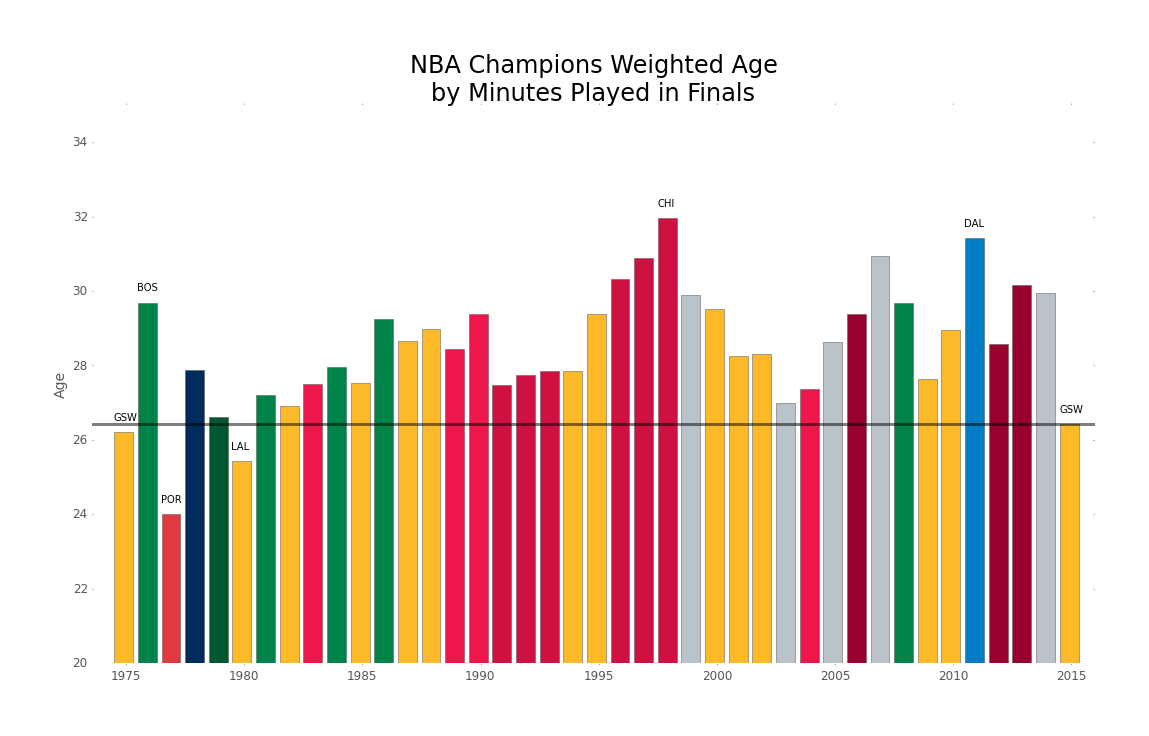

In [455]:
fig, ax = plt.subplots( figsize = (18, 10))
# ax.bar(range(0, len(dfhts)*5, 5), dfhts.mp_age, width = 4)
ax.bar([.5 + s for s in dfhts.season], dfhts.mp_age, color= [team_colors[t] for t in dfhts.team.values])
#ax.axhline(dfhts.mp_age.median())
ax.axhline(dfhts.loc[dfhts.season == 2015, 'mp_age'].values[0], color = 'black', alpha = 0.5)
ax.set_xlim((min(SEASON_RANGE)-.5, max(SEASON_RANGE)+2))
ax.set_ylim((20, 35))

ax.set_xticks(range(1976, 2017, 5))
ax.set_xticklabels([x-1 for x in (range(1976, 2017, 5))])
yrs_to_annotate=[1975, 1977, 1980, 1998, 2011, 1976, 2015]
for y in yrs_to_annotate:
    r = dfhts.loc[dfhts.season == y, :]
    ax.annotate(r.team.values[0], xy = (r.season.values[0]+.5, r.mp_age.values[0]+.33))
 
ax.set_title('NBA Champions Weighted Age\nby Minutes Played in Finals', fontsize = 24)
ax.set_ylabel('Age')
plt.savefig('nba_champs_age.png', )

In [454]:
df_all[df_all.season== 2011].sort('mp', ascending=False)

,season,team,player,age,mp,pts,ht,inches,mp_perc,mp_age,mp_inches
413,2011,DAL,Dirk Nowitzki,32,242,156,7-0,84,0.168056,5.377778,14.116667
418,2011,DAL,Jason Kidd,37,225,46,6-4,76,0.156250,5.781250,11.875000
416,2011,DAL,Tyson Chandler,28,224,58,7-1,85,0.155556,4.355556,13.222222
415,2011,DAL,Shawn Marion,32,215,82,6-7,79,0.149306,4.777778,11.795139
414,2011,DAL,Jason Terry,33,195,108,6-2,74,0.135417,4.468750,10.020833
417,2011,DAL,Jose Barea,26,128,53,6-0,72,0.088889,2.311111,6.400000
419,2011,DAL,DeShawn Stevenson,29,103,42,6-5,77,0.071528,2.074306,5.507639
421,2011,DAL,Brian Cardinal,33,30,7,6-8,80,0.020833,0.687500,1.666667
420,2011,DAL,Ian Mahinmi,24,27,9,6-11,83,0.018750,0.450000,1.556250
423,2011,DAL,Peja Stojakovic,33,26,2,6-9,81,0.018056,0.595833,1.462500
